In [210]:
!pip install tensorflow opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [112]:
!pip list

Package                           Version
--------------------------------- ------------------
absl-py                           2.3.1
aext-assistant                    4.1.0
aext-assistant-server             4.1.0
aext-core                         4.1.0
aext-core-server                  4.1.0
aext-panels                       4.1.0
aext-panels-server                4.1.0
aext-project-filebrowser-server   4.1.0
aext-share-notebook               4.1.0
aext-share-notebook-server        4.1.0
aext-shared                       4.1.0
aext-toolbox                      4.1.0
aiobotocore                       2.12.3
aiohappyeyeballs                  2.4.0
aiohttp                           3.10.5
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.16
alembic                           1.13.3
altair                            5.0.1
anaconda-anon-usage               0.4.4
anaconda-catalogs                 0.2.0
anaconda-cli-base    

In [114]:
import tensorflow as tf
import os

In [116]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [118]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [121]:
import cv2
import imghdr

In [123]:
data_dir = 'data' 

In [125]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [127]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Issue with image data\happy\.ipynb_checkpoints
Issue with image data\sad\.ipynb_checkpoints


# 3. Load Data

In [130]:
import numpy as np
from matplotlib import pyplot as plt

In [132]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 308 files belonging to 2 classes.


In [134]:
data_iterator = data.as_numpy_iterator()

In [136]:
batch = data_iterator.next()

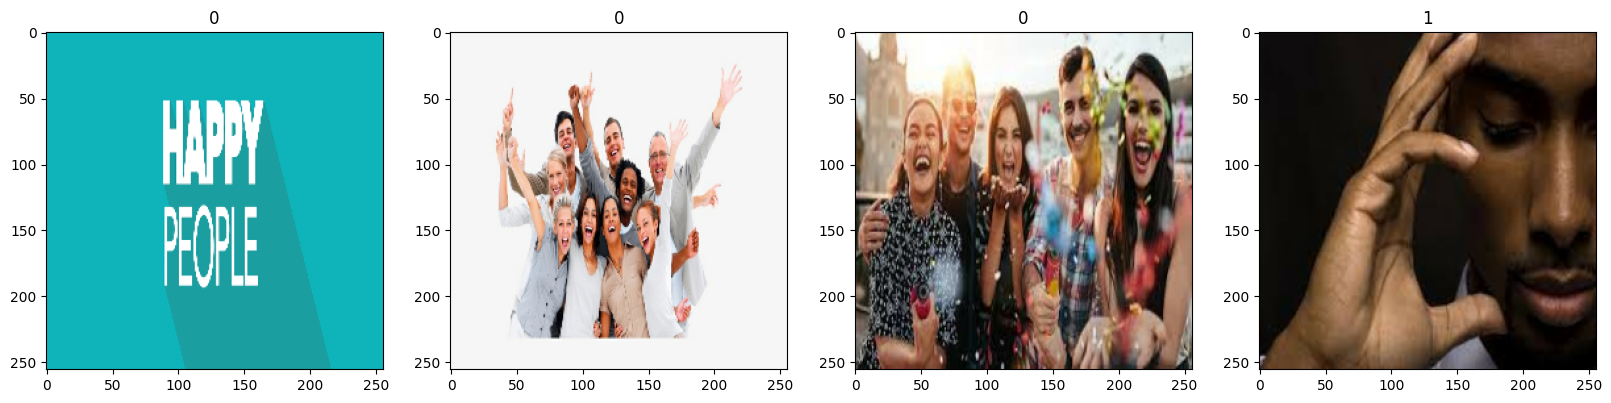

In [138]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [141]:
data = data.map(lambda x,y: (x/255, y))

In [143]:
data.as_numpy_iterator().next()

(array([[[[6.56786188e-02, 5.78354783e-02, 6.17570467e-02],
          [6.56786188e-02, 5.78354783e-02, 6.17570467e-02],
          [6.56786188e-02, 5.78354783e-02, 6.17570467e-02],
          ...,
          [4.28130597e-01, 2.83032566e-01, 2.08522752e-01],
          [4.27865475e-01, 2.86689013e-01, 2.00155929e-01],
          [4.29172367e-01, 2.87995905e-01, 1.93878263e-01]],
 
         [[5.97809441e-02, 5.19378074e-02, 5.58593757e-02],
          [5.97809441e-02, 5.19378074e-02, 5.58593757e-02],
          [5.97809441e-02, 5.19378074e-02, 5.58593757e-02],
          ...,
          [4.17974800e-01, 2.75840908e-01, 1.92438632e-01],
          [4.27359074e-01, 2.86182612e-01, 1.98881745e-01],
          [3.99864882e-01, 2.58688420e-01, 1.64570749e-01]],
 
         [[5.98422177e-02, 5.19990809e-02, 5.59206493e-02],
          [5.98422177e-02, 5.19990809e-02, 5.59206493e-02],
          [5.98422177e-02, 5.19990809e-02, 5.59206493e-02],
          ...,
          [4.28352267e-01, 2.87175804e-01, 1.9305

# 5. Split Data

In [146]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [148]:
train_size

7

In [150]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [153]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [155]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [157]:
model = Sequential()

In [159]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [161]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [163]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [166]:
logdir='logs'

In [168]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [170]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5491 - loss: 0.6920 - val_accuracy: 0.8125 - val_loss: 0.6595
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7277 - loss: 0.5890 - val_accuracy: 0.8125 - val_loss: 0.4556
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7946 - loss: 0.5110 - val_accuracy: 0.8438 - val_loss: 0.4113
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8795 - loss: 0.3654 - val_accuracy: 0.7344 - val_loss: 0.5332
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8438 - loss: 0.3601 - val_accuracy: 0.9531 - val_loss: 0.2888
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9152 - loss: 0.2677 - val_accuracy: 0.9375 - val_loss: 0.1976
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9152 - loss: 0.2397 - val_accuracy: 0.9844 - val_loss: 0.1000
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9330 - loss: 0.1648 - val_accuracy: 0.9375 - val_loss: 0.2098
Epoch 9/20
7/7 

# 8. Plot Performance

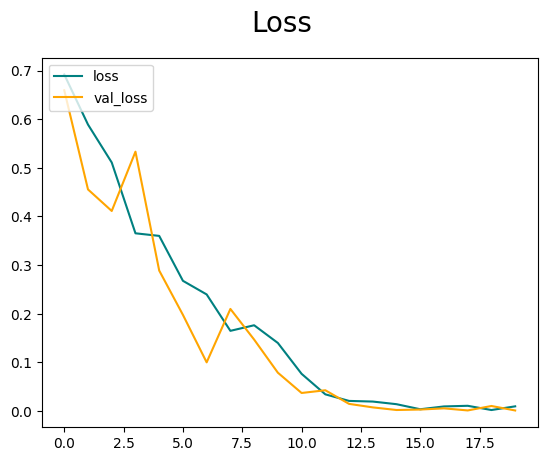

In [172]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

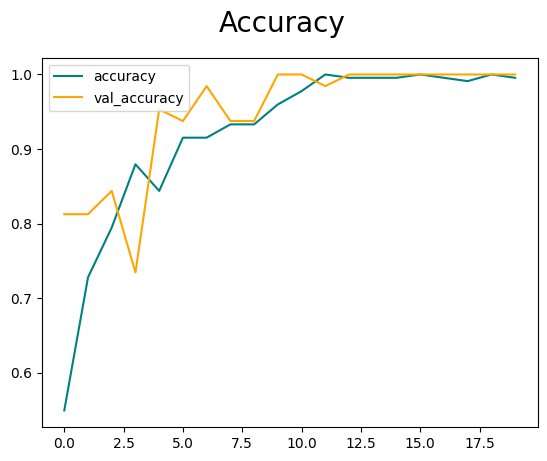

In [174]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [177]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [179]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [181]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


In [183]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()},Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0,Accuracy:1.0


# 10. Test

In [186]:
import cv2

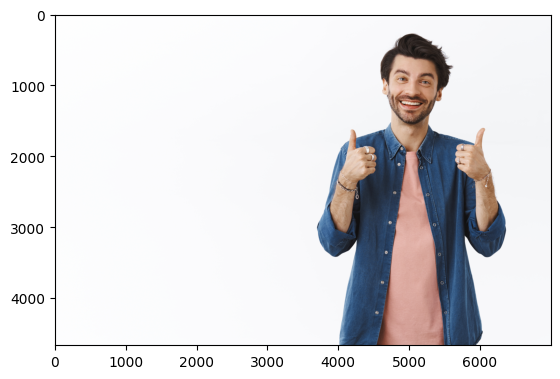

In [188]:
img = cv2.imread('happytest3.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

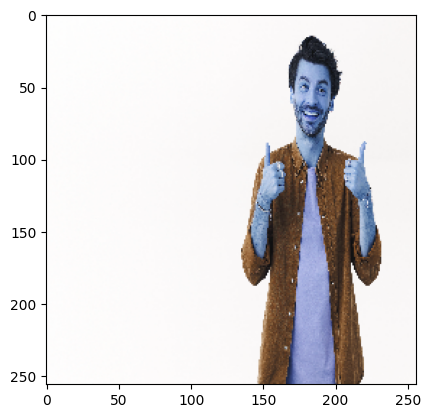

In [189]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [191]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


In [194]:
yhat

array([[0.01833646]], dtype=float32)

In [196]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [199]:
from tensorflow.keras.models import load_model

In [201]:
model.save(os.path.join('models','happysad.keras'))

In [203]:
new_model = load_model(os.path.join('models','happysad.keras'))

In [204]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


array([[0.01833646]], dtype=float32)